In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from google.colab import drive
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np
from sklearn.metrics import f1_score

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_val, axis=1)
        f1 = f1_score(y_true, y_pred, average='macro')
        print("F1 score: {:.4f}".format(f1))
        self.f1_scores.append(f1)


data = pd.read_csv('/with_title_data.csv')

labels = pd.Categorical(data['sectionName']).codes

one_hot_labels = to_categorical(labels)

data = pd.concat([data.drop('sectionName', axis=1), pd.DataFrame(one_hot_labels)], axis=1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['bodyContent'].astype(str))
sequences = tokenizer.texts_to_sequences(data['bodyContent'].astype(str))

vocab_size = len(tokenizer.word_index) + 1

max_len = (max([len(x) for x in sequences]) + min([len(x) for x in sequences]))//2
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

In [ ]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

In [ ]:

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(SimpleRNN(units=64))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

print("loading embedding")
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], dtype=tf.string)

X_train, X_test, y_train, y_test = train_test_split(data['bodyContent'].astype(str), one_hot_labels, test_size=0.2, random_state=42)

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = Sequential()
model.add(hub_layer)
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 2457, 128)         28855296  
                                                                 
 conv1d_1 (Conv1D)           (None, 2455, 25)          9625      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 128)               3328      
                                                                 
 dense_25 (Dense)            (None, 77)                9933      
                                                                 
Total params: 28,878,182
Trainable params: 28,878,182
Non-trainable params: 0
_________________________________________

<Axes: >

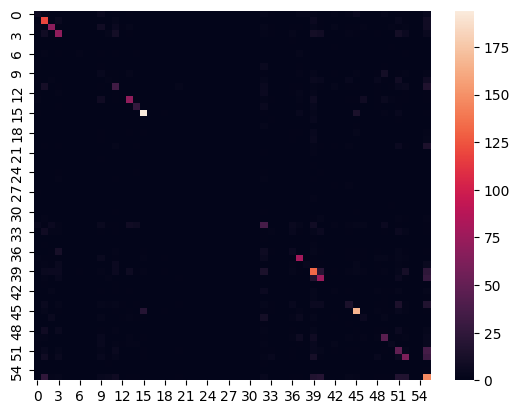

In [ ]:
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Conv1D(25,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[checkpoint,f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 128)           28855296  
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dense_29 (Dense)            (None, 77)                9933      
                                                                 
Total params: 28,922,957
Trainable params: 28,922,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
84/84 [========================

<Axes: >

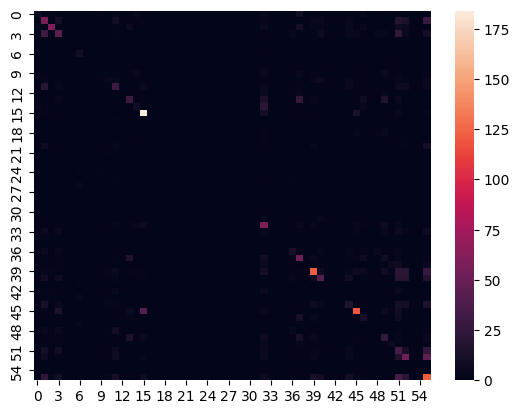

In [ ]:

max_len = 50
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 128)           28855296  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_30 (Dense)            (None, 128)               8320      
                                                                 
 dense_31 (Dense)            (None, 77)                9933      
                                                                 
Total params: 28,885,901
Trainable params: 28,885,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
84/84 [==============================] - 21s 226ms/step - loss: 3.4886 - accuracy: 0.0898 - val_loss: 3.2844 - val_accuracy: 0.1092
Epoch 2/5
84/84 [==============

<Axes: >

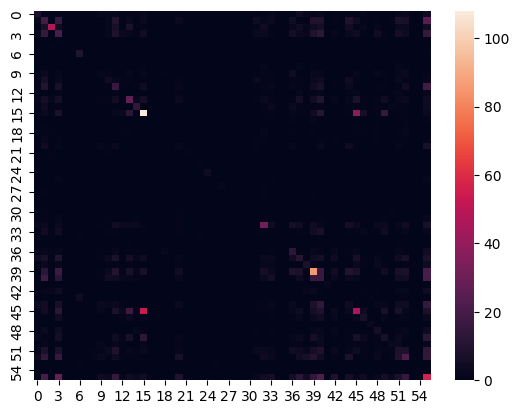

In [ ]:
max_len = 50
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(SimpleRNN(units=64))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

In [ ]:
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)


In [ ]:
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Input
from tensorflow.keras.models import Model

input = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input) 

c1 = Conv1D(100,3,padding='same',activation='relu',strides=1)(embedding)
c2 = Conv1D(100,5,padding='same',activation='relu',strides=1)(embedding)
c3 = Conv1D(100,10,padding='same',activation='relu',strides=1)(embedding)

c = concatenate([c1, c2, c3])

p = GlobalMaxPooling1D()(c)

d = Dense(units=128, activation='relu')(p)

output = Dense(units=y_train.shape[1], activation='softmax')(d)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

loading embedding
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 77)                9933      
                                                                 
Total params: 256,873,421
Trainable params: 75,597
Non-trainable params: 256,797,824
_________________________________________________________________
Epoch 1/5
84/84 [==============================] - ETA: 0s - loss: 3.3998 - accuracy: 0.1963
Epoch 1: val_accuracy improved from -inf to 0.29748, saving model to /content/drive/MyDrive/checkpoints/weights-improvement-01-0.30.hdf5
93/93 [==============================] - 7s 67ms/step

<Axes: >

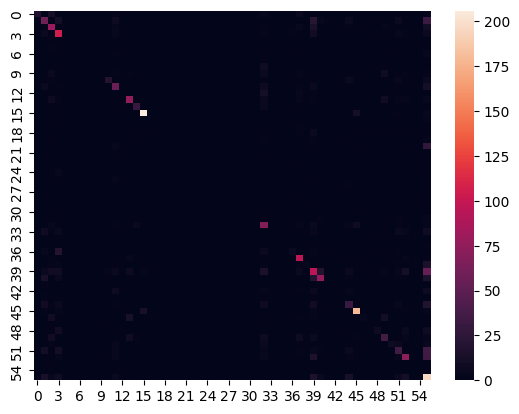

In [3]:
import tensorflow_hub as hub
import tensorflow as tf

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
print("loading embedding")
embed = hub.load(module_url)
hub_layer = hub.KerasLayer(module_url, output_shape=[512], input_shape=[], dtype=tf.string)

X_train, X_test, y_train, y_test = train_test_split(data['bodyContent'].astype(str), one_hot_labels, test_size=0.2, random_state=42)

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = Sequential()
model.add(hub_layer)
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[checkpoint,f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

In [ ]:
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Input, Add
from tensorflow.keras.models import Model

max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

input = Input(shape=(max_len,)) 

embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input) 
lstm1 = LSTM(units=128,return_sequences=True)(embedding)
lstm_res1 = Add()([embedding, lstm1])


lstm2 = LSTM(units=128,return_sequences=True)(lstm_res1)
lstm_res2 = Add()([lstm1, lstm2])

lstm3 = LSTM(units=128)(lstm_res2)
d = Dropout(0.5)(lstm3)

output = Dense(units=y_train.shape[1], activation='softmax')(d)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)

In [ ]:

title_sequences = tokenizer.texts_to_sequences(data['webTitle'].astype(str))

vocab_size = len(tokenizer.word_index) + 1

title_max_len = max([len(x) for x in title_sequences])
title_padded_sequences = pad_sequences(title_sequences, maxlen=title_max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(title_padded_sequences, one_hot_labels, test_size=0.2, random_state=42)


from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=title_max_len))
model.add(Conv1D(25,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[checkpoint,f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 2457)]       0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding_29 (Embedding)       (None, 2457, 128)    28855296    ['input_29[0][0]']               
                                                                                                  
 embedding_30 (Embedding)       (None, 20, 128)      28855296    ['input_30[0][0]']               
                                                                                            

<Axes: >

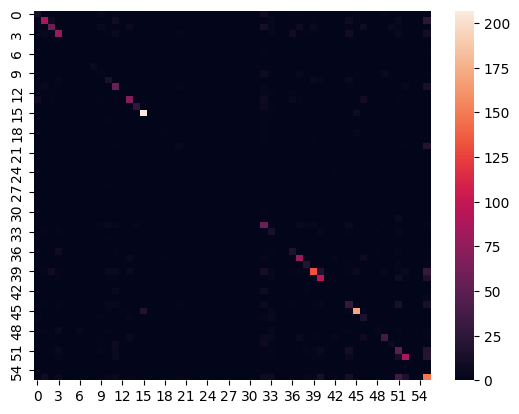

In [24]:

title_sequences = tokenizer.texts_to_sequences(data['webTitle'].astype(str))

vocab_size = len(tokenizer.word_index) + 1

title_max_len = max([len(x) for x in title_sequences])
title_padded_sequences = pad_sequences(title_sequences, maxlen=title_max_len, padding='post')

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(padded_sequences, title_padded_sequences, one_hot_labels, test_size=0.2, random_state=42)


from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, Input, Add
from tensorflow.keras.models import Model

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

input_body = Input(shape=(max_len,))
input_title = Input(shape=(title_max_len,))
embedding1 = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input_body) # 定义嵌入层
embedding2 = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input_title) # 定义嵌入层
conv1 = Conv1D(25,3,padding='valid',activation='relu',strides=1)(embedding1)
conv2 = Conv1D(25,3,padding='valid',activation='relu',strides=1)(embedding2)
pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)

x = Add()([pool1, pool2])

d = Dense(units=128, activation='relu')(x)

output = Dense(units=y_train.shape[1], activation='softmax')(d)

model = Model(inputs=[input_body,input_title], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit( [X1_train,X2_train], y_train, epochs=5, batch_size=128, validation_split=0.1)

loss, accuracy = model.evaluate([X1_test,X2_test], y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict([X1_test,X2_test])

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(56)],columns=[i for i in range(56)])

sns.heatmap(df,annot=False)


In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from google.colab import drive
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np

data = pd.read_csv('with_title_data.csv')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

data = data.dropna(subset=['bodyContent'])

X_train, X_test, y_train, y_test = train_test_split(data['bodyContent'], data['sectionName'], test_size=0.1, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = svm_model.score(X_test, y_test)


Mounted at /content/drive


In [ ]:
print('Accuracy:{}'.format(accuracy))

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=False, cmap='Blues', fmt='g', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
